In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Data and Libraries

In [ ]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from scipy.sparse import hstack
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn.model_selection import cross_validate 
from sklearn.metrics import ConfusionMatrixDisplay as cmd

CPU times: user 779 ms, sys: 443 ms, total: 1.22 s
Wall time: 1.37 s


In [ ]:
mvp_cat = ['Abstract', 'Response to reviewer comments',
       'Research paper_Journal article']

np.random.seed(42)
df = pd.read_csv("/content/drive/MyDrive/PlakshaNLP/capstone/data_json_space_corrected_with_tables_try.csv")
df.loc[df.heading_text.isnull(), "heading_text"] = ""
df = df.loc[(df["text"].notnull())]
df["raw_category"]  = df.doc_category.copy()
# df.loc[df.doc_category.isin(rp_type), "doc_category"] = 'Research paper_Journal article'
df.loc[~df.doc_category.isin(mvp_cat), "doc_category"] = "Other"
df["rtrc"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Response to reviewer comments"), "rtrc"] = "non-rtrc"
df.loc[(df.doc_category == "Response to reviewer comments"), "rtrc"] = "rtrc"
df["abstract"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Abstract"), "abstract"] = "non-abstract"
df.loc[(df.doc_category == "Abstract"), "abstract"] = "abstract"
df["rp"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Research paper_Journal article"), "rp"] = "non-rp"
df.loc[(df.doc_category == "Research paper_Journal article"), "rp"] = "rp"
df["word_count2"] = df.text.str.split(" ").apply(len)
df = df.loc[(df["word_count2"] > 50)].reset_index()
df_mvp = df.loc[df.doc_category.isin(mvp_cat)].reset_index(drop=True)

# df_raw = df.loc[~df.index.isin(df.loc[df.doc_category == "Other"].sample(frac=0.87, random_state  =42).index)].reset_index(drop = True)
# df = df.loc[~df.index.isin(df.loc[df.doc_category == "Other"].sample(frac=0.87, random_state  =42).index)].reset_index(drop = True)

df_allcat_train_cv, df_allcat_test = train_test_split(df, test_size = 0.1, random_state =42)
df_allcat_train, df_allcat_val = train_test_split(df_allcat_train_cv, test_size = 0.1111, random_state =42)
df_allcat_train = df_allcat_train.reset_index(drop = True)
df_allcat_train_cv = df_allcat_train_cv.reset_index(drop = True)
df_allcat_val = df_allcat_val.reset_index(drop = True)
df_allcat_test = df_allcat_test.reset_index(drop = True)

# Numerical Feature Analysis

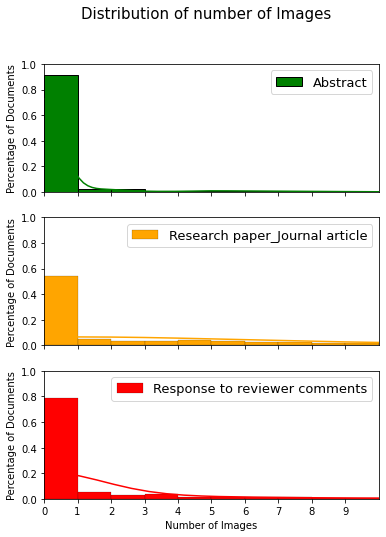

In [ ]:
#Number of Images
fig, axes = plt.subplots(3,1,figsize = (6,8), sharex  = True)
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[0]].n_images.values, ax=axes[0], label = mvp_cat[0], color = "green", kde = True, binwidth = 1, alpha = 1, stat="probability")
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[2]].n_images.values, ax=axes[1], label = mvp_cat[2],color = "orange", kde = True, binwidth = 1, alpha = 1, stat="probability") 
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[1]].n_images.values, ax=axes[2], label = mvp_cat[1],color = "red", kde = True, binwidth = 1, alpha = 1, stat="probability")
axes[0].legend(loc=1, prop={'size': 13}) 
axes[1].legend(loc=1, prop={'size': 13}) 
axes[2].legend(loc=1, prop={'size': 13}) 
axes[0].set_ylabel("Percentage of Documents")
axes[1].set_ylabel("Percentage of Documents")
axes[2].set_ylabel("Percentage of Documents")
axes[0].set_ylim(0,1)
axes[1].set_ylim(0,1)
axes[2].set_ylim(0,1)
plt.xlabel("Number of Images")
plt.xlim(0,10)
plt.xticks(ticks = np.arange(0,10), labels = np.arange(0,10))
plt.suptitle("Distribution of number of Images", fontsize = 15)
plt.show()

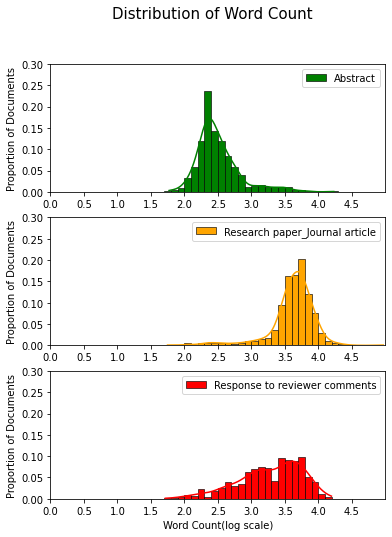

In [ ]:
#Word count
fig, axes = plt.subplots(3,1,figsize = (6,8))
sns.histplot(np.log10(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[0]].word_count2.values), ax=axes[0], label = mvp_cat[0], color = "green", kde = True, binwidth = 0.1, alpha = 1, stat="proportion", binrange = (0,5))
sns.histplot(np.log10(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[2]].word_count2.values), ax=axes[1], label = mvp_cat[2],color = "orange", kde = True, binwidth = 0.1, alpha = 1, stat="proportion", binrange = (0,5)) 
sns.histplot(np.log10(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[1]].word_count2.values), ax=axes[2], label = mvp_cat[1],color = "red", kde = True, binwidth = 0.1, alpha = 1, stat="proportion", binrange = (0,5))
axes[0].legend(loc=1, prop={'size': 10}) 
axes[1].legend(loc=1, prop={'size': 10}) 
axes[2].legend(loc=1, prop={'size': 10}) 
axes[0].set_ylabel("Proportion of Documents")
axes[1].set_ylabel("Proportion of Documents")
axes[2].set_ylabel("Proportion of Documents")
axes[0].set_ylim(0,0.3)
axes[1].set_ylim(0,0.3)
axes[2].set_ylim(0,0.3)
axes[0].set_xlim(0,5)
axes[1].set_xlim(0,5)
axes[2].set_xlim(0,5)
axes[0].set_xticks(ticks = np.arange(0,5,0.5))
axes[1].set_xticks(ticks = np.arange(0,5,0.5))
axes[2].set_xticks(ticks = np.arange(0,5,0.5))
plt.xlabel("Word Count(log scale)")
# plt.xticks(ticks = np.arange(0,5,0.5), labels = np.arange(0,5, 0.5))
plt.suptitle("Distribution of Word Count", fontsize = 15)
plt.show()

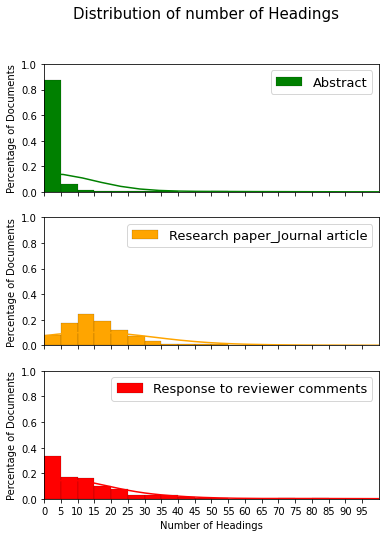

In [ ]:
#Number of Headings
fig, axes = plt.subplots(3,1,figsize = (6,8), sharex  = True)
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[0]].n_headings.values, ax=axes[0], label = mvp_cat[0], color = "green", kde = True, binwidth = 5, alpha = 1, stat="probability")
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[2]].n_headings.values, ax=axes[1], label = mvp_cat[2],color = "orange", kde = True, binwidth = 5, alpha = 1, stat="probability") 
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[1]].n_headings.values, ax=axes[2], label = mvp_cat[1],color = "red", kde = True, binwidth = 5, alpha = 1, stat="probability")
axes[0].legend(loc=1, prop={'size': 13}) 
axes[1].legend(loc=1, prop={'size': 13}) 
axes[2].legend(loc=1, prop={'size': 13}) 
axes[0].set_ylabel("Percentage of Documents")
axes[1].set_ylabel("Percentage of Documents")
axes[2].set_ylabel("Percentage of Documents")
axes[0].set_ylim(0,1)
axes[1].set_ylim(0,1)
axes[2].set_ylim(0,1)
plt.xlabel("Number of Headings")
plt.xlim(0,100)
plt.xticks(ticks = np.arange(0,100, 5), labels = np.arange(0,100, 5))
plt.suptitle("Distribution of number of Headings", fontsize = 15)
plt.show()

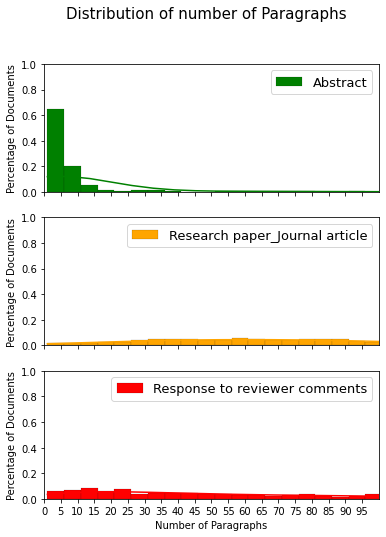

In [ ]:
#Number of Paragraphs
fig, axes = plt.subplots(3,1,figsize = (6,8), sharex  = True)
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[0]].n_paragraphs.values, ax=axes[0], label = mvp_cat[0], color = "green", kde = True, binwidth = 5, alpha = 1, stat="probability")
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[2]].n_paragraphs.values, ax=axes[1], label = mvp_cat[2],color = "orange", kde = True, binwidth = 5, alpha = 1, stat="probability") 
sns.histplot(df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == mvp_cat[1]].n_paragraphs.values, ax=axes[2], label = mvp_cat[1],color = "red", kde = True, binwidth = 5, alpha = 1, stat="probability")
axes[0].legend(loc=1, prop={'size': 13}) 
axes[1].legend(loc=1, prop={'size': 13}) 
axes[2].legend(loc=1, prop={'size': 13}) 
axes[0].set_ylabel("Percentage of Documents")
axes[1].set_ylabel("Percentage of Documents")
axes[2].set_ylabel("Percentage of Documents")
axes[0].set_ylim(0,1)
axes[1].set_ylim(0,1)
axes[2].set_ylim(0,1)
plt.xlabel("Number of Paragraphs")
plt.xlim(0,100)
plt.xticks(ticks = np.arange(0,100, 5), labels = np.arange(0,100, 5))
plt.suptitle("Distribution of number of Paragraphs", fontsize = 15)
plt.show()

In [ ]:
df_allcat_train_cv.columns

Index(['index', 'doc_name', 'doc_category', 'domain', ' status', 'word_count',
       'n_tables', 'n_paragraphs', 'n_images', 'n_headings', 'heading_text',
       'text', 'raw_category', 'rtrc', 'abstract', 'rp', 'word_count2'],
      dtype='object')

In [ ]:
df_allcat_train_cv[['word_count','n_paragraphs', 'n_images', 'n_headings']]

,word_count,n_paragraphs,n_images,n_headings
0,113,4,0,3
1,18301,155,0,28
2,2743,30,0,18
3,313,3,0,0
4,2820,58,0,7
...,...,...,...,...
2399,3716,29,0,8
2400,1458,32,4,15
2401,103,2,0,0
2402,10520,159,4,16


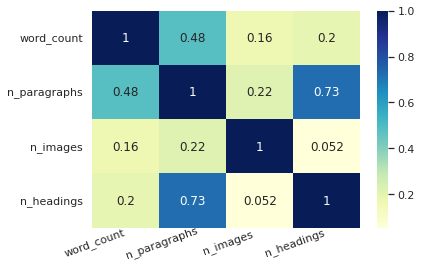

In [ ]:
dataplot = sns.heatmap(df_allcat_train_cv[['word_count','n_paragraphs', 'n_images', 'n_headings']].corr(), cmap="YlGnBu", annot=True)
sns.set(font_scale=1)
plt.xticks((0,1,2,3), ['word_count','n_paragraphs', 'n_images', 'n_headings'], rotation=20, rotation_mode="anchor")
# displaying heatmap
plt.show()

In [ ]:
!cat /proc/meminfo

MemTotal:       26692016 kB
MemFree:        23465264 kB
MemAvailable:   25218712 kB
Buffers:          131172 kB
Cached:          1805148 kB
SwapCached:            0 kB
Active:          1585776 kB
Inactive:        1391748 kB
Active(anon):     947156 kB
Inactive(anon):      504 kB
Active(file):     638620 kB
Inactive(file):  1391244 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               500 kB
Writeback:             0 kB
AnonPages:       1041156 kB
Mapped:           231616 kB
Shmem:              1200 kB
KReclaimable:      93772 kB
Slab:             159264 kB
SReclaimable:      93772 kB
SUnreclaim:        65492 kB
KernelStack:        5584 kB
PageTables:        14680 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13346008 kB
Committed_AS:    3298312 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        7984 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

# Key Word Analysis

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from tqdm import tqdm

stop_words = set(stopwords.words('english'))

def tokenize(text):
    '''
    It takes text, removes stopwords and returns list of stemmed tokens
    '''
    word_tokens = nltk.word_tokenize(text)
    #Removing stopwords
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    stems = []
    for item in filtered_sentence:
        stems.append(PorterStemmer().stem(item))
    return stems

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


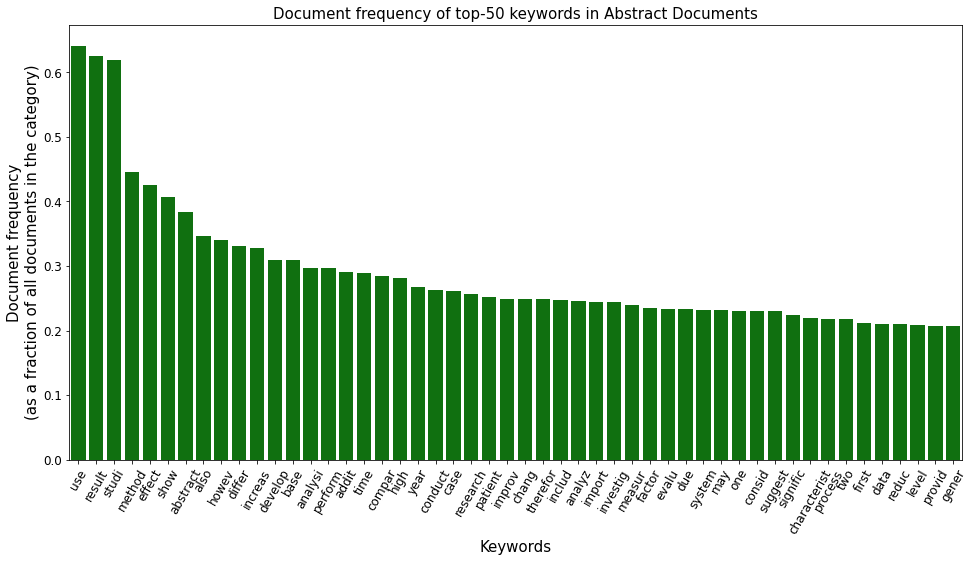

In [ ]:
#Finding Most Frequent Words for Abstracts
abstract_df = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == 'Abstract']

#Finding Document Frequency of each keyword
tfidf_abstract = TfidfVectorizer(tokenizer=tokenize, ngram_range = (1,2), use_idf = None, norm = None, binary = True)
abstract_corpus_vector = tfidf_abstract.fit_transform(abstract_df.text)
abstract_corpus_vector_df = pd.DataFrame(abstract_corpus_vector.toarray())
abstract_corpus_vector_df.columns = tfidf_abstract.get_feature_names_out()

doc_freq = abstract_corpus_vector_df.sum(axis = 0).values
abstract_keywords = abstract_corpus_vector_df.sum(axis = 0).index[np.argsort(doc_freq)[::-1]]
abstract_sort_doc_freq = np.sort(doc_freq)[::-1]/abstract_df.shape[0]

#Plotting top 20 keywords in terms of document frequency within Abstract Category
fig = plt.figure(figsize = (16,8))
sns.barplot(x = abstract_keywords[:50], y = abstract_sort_doc_freq[:50], color = "green")
plt.xticks(rotation = 60, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Document frequency of top-50 keywords in Abstract Documents", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency\n(as a fraction of all documents in the category)", fontsize = 15)
plt.show()

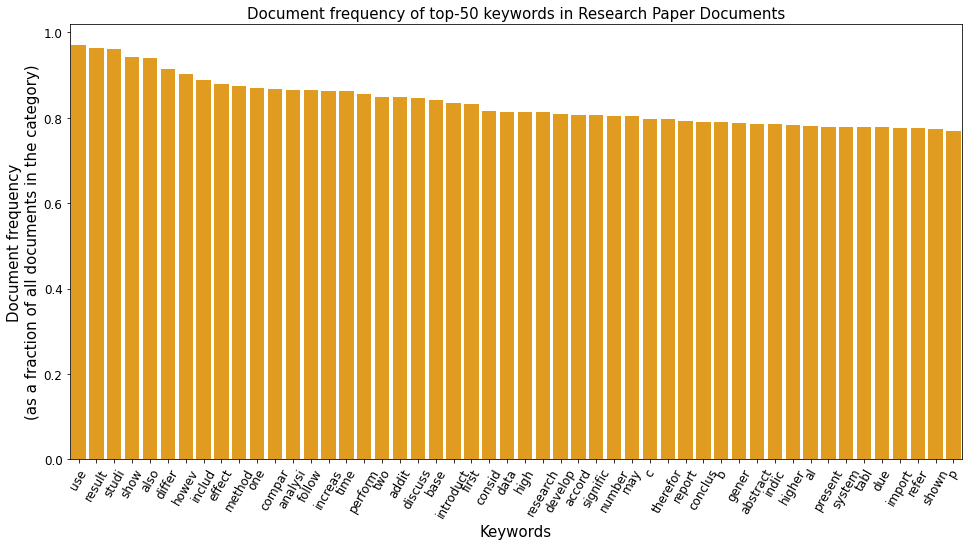

In [ ]:
#Finding Most Frequent Words for RP
rp_df = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == 'Research paper_Journal article']

#Finding Document Frequency of each keyword
tfidf_rp = TfidfVectorizer(tokenizer=tokenize,ngram_range = (1,2), use_idf = None, norm = None, binary = True)
rp_corpus_vector = tfidf_rp.fit_transform(rp_df.text)
rp_corpus_vector_df = pd.DataFrame(rp_corpus_vector.toarray())
rp_corpus_vector_df.columns = tfidf_rp.get_feature_names_out()

doc_freq = rp_corpus_vector_df.sum(axis = 0).values
rp_keywords = rp_corpus_vector_df.sum(axis = 0).index[np.argsort(doc_freq)[::-1]]
rp_sort_doc_freq = np.sort(doc_freq)[::-1]/rp_df.shape[0]

#Plotting top 20 keywords in terms of document frequency within Research Paper Category
fig = plt.figure(figsize = (16,8))
sns.barplot(x = rp_keywords[:50], y = rp_sort_doc_freq[:50], color = "orange")
plt.xticks(rotation = 60, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Document frequency of top-50 keywords in Research Paper Documents", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency\n(as a fraction of all documents in the category)", fontsize = 15)
plt.show()

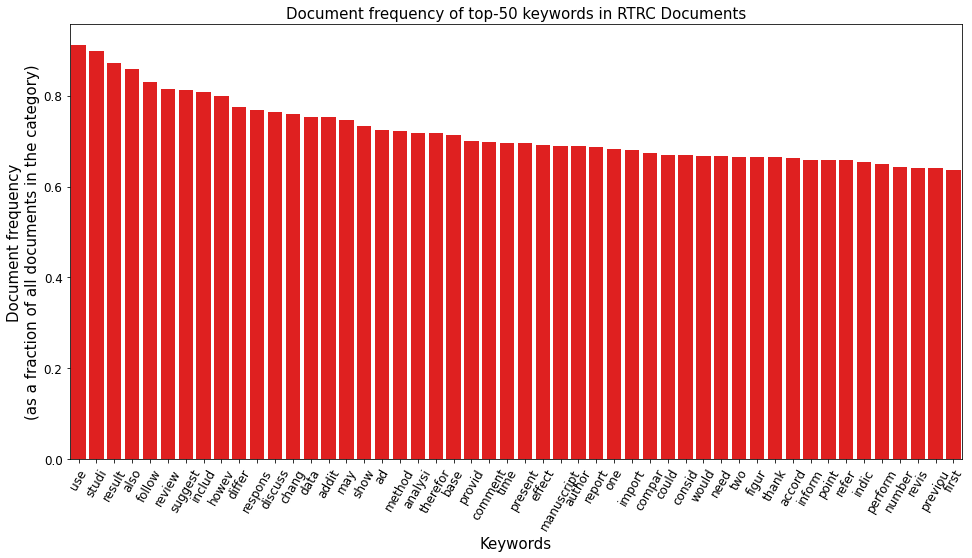

In [ ]:
#Finding Most Frequent Words for RTRC
rtrc_df = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == 'Response to reviewer comments']

#Finding Document Frequency of each keyword
tfidf_rtrc = TfidfVectorizer(tokenizer=tokenize, ngram_range = (1,2), use_idf = None, norm = None, binary = True)
rtrc_corpus_vector = tfidf_rtrc.fit_transform(rtrc_df.text)
rtrc_corpus_vector_df = pd.DataFrame(rtrc_corpus_vector.toarray())
rtrc_corpus_vector_df.columns = tfidf_rtrc.get_feature_names_out()

doc_freq = rtrc_corpus_vector_df.sum(axis = 0).values
rtrc_keywords = rtrc_corpus_vector_df.sum(axis = 0).index[np.argsort(doc_freq)[::-1]]
rtrc_sort_doc_freq = np.sort(doc_freq)[::-1]/rtrc_df.shape[0]

#Plotting top 20 keywords in terms of document frequency within rtrc Category
fig = plt.figure(figsize = (16,8))
sns.barplot(x = rtrc_keywords[:50], y = rtrc_sort_doc_freq[:50], color = "red")
plt.xticks(rotation = 60, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Document frequency of top-50 keywords in RTRC Documents", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency\n(as a fraction of all documents in the category)", fontsize = 15)
plt.show()

# Find unique heading keyword for each category

In [ ]:
abstract_keyword_dfreq_dict = {}
for i,j in zip(abstract_keywords, abstract_sort_doc_freq):
  abstract_keyword_dfreq_dict[i] = j
rtrc_keyword_dfreq_dict = {}
for i,j in zip(rtrc_keywords, rtrc_sort_doc_freq):
  rtrc_keyword_dfreq_dict[i] = j
rp_keyword_dfreq_dict = {}
for i,j in zip(rp_keywords, rp_sort_doc_freq):
  rp_keyword_dfreq_dict[i] = j

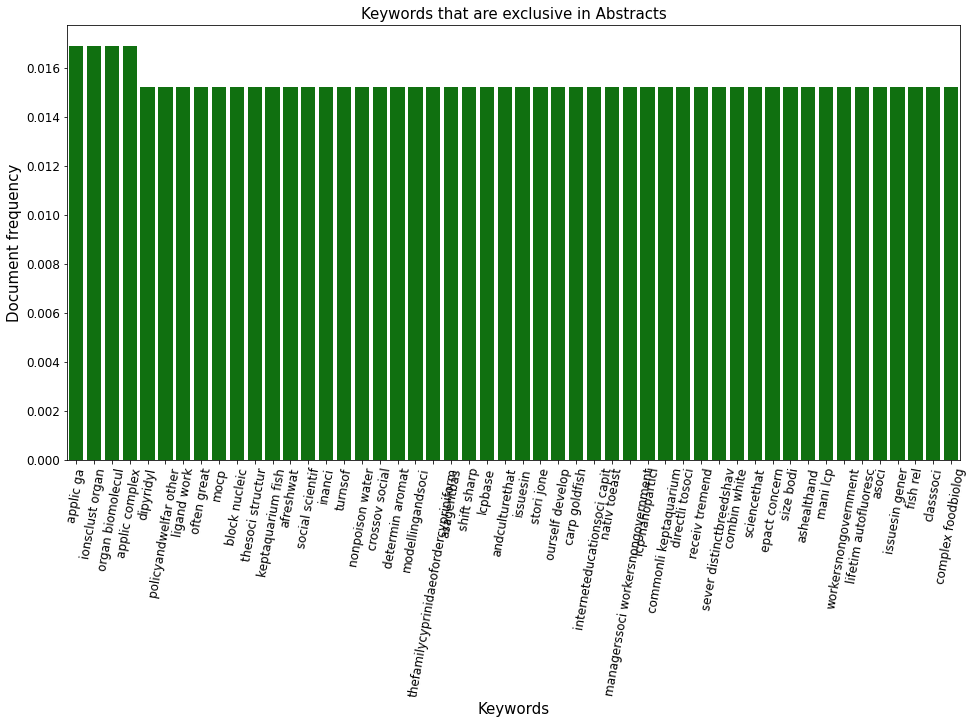

In [ ]:
#For Abstracts
only_abstract_keywords = np.array(list(set(abstract_keywords) - set(rtrc_keywords) - set(rp_keywords)))
only_abstract_keywords_dfreq = np.array([abstract_keyword_dfreq_dict[i] for i in only_abstract_keywords])
only_abstract_keywords = only_abstract_keywords[np.argsort(only_abstract_keywords_dfreq)][::-1]
only_abstract_keywords_dfreq = only_abstract_keywords_dfreq[np.argsort(only_abstract_keywords_dfreq)][::-1]

fig = plt.figure(figsize = (16,8))
sns.barplot(x = only_abstract_keywords[:50], y = only_abstract_keywords_dfreq[:50], color = "green")
plt.xticks(rotation = 80, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Keywords that are exclusive in Abstracts", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency", fontsize = 15)
plt.show()

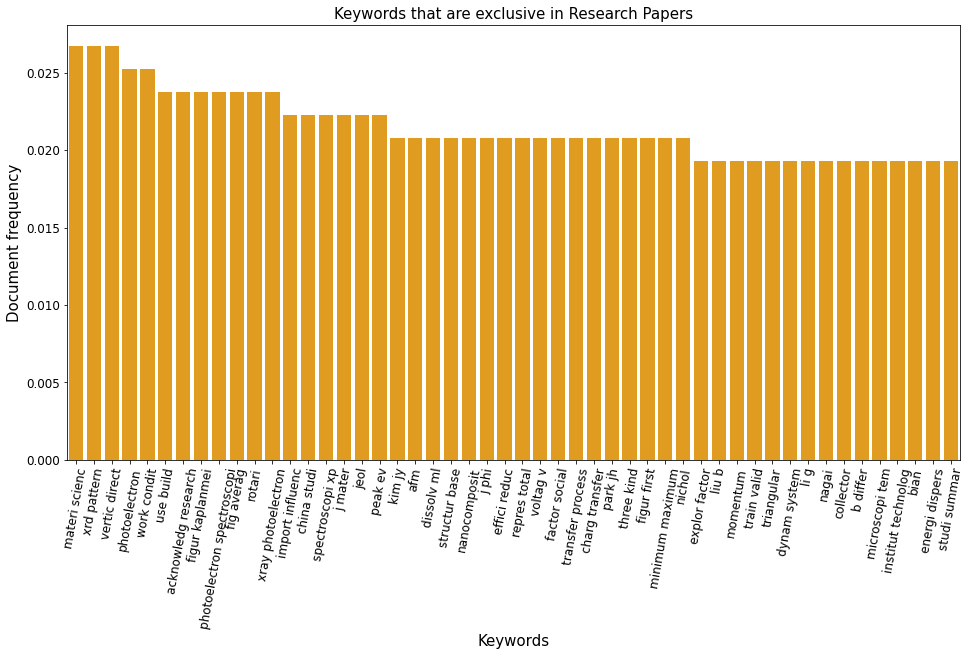

In [ ]:
#For Research Papers
only_rp_keywords = np.array(list(set(rp_keywords) - set(rtrc_keywords) - set(abstract_keywords)))
only_rp_keywords_dfreq = np.array([rp_keyword_dfreq_dict[i] for i in only_rp_keywords])
only_rp_keywords = only_rp_keywords[np.argsort(only_rp_keywords_dfreq)][::-1]
only_rp_keywords_dfreq = only_rp_keywords_dfreq[np.argsort(only_rp_keywords_dfreq)][::-1]

fig = plt.figure(figsize = (16,8))
sns.barplot(x = only_rp_keywords[:50], y = only_rp_keywords_dfreq[:50], color = "orange")
plt.xticks(rotation = 80, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Keywords that are exclusive in Research Papers", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency", fontsize = 15)
plt.show()

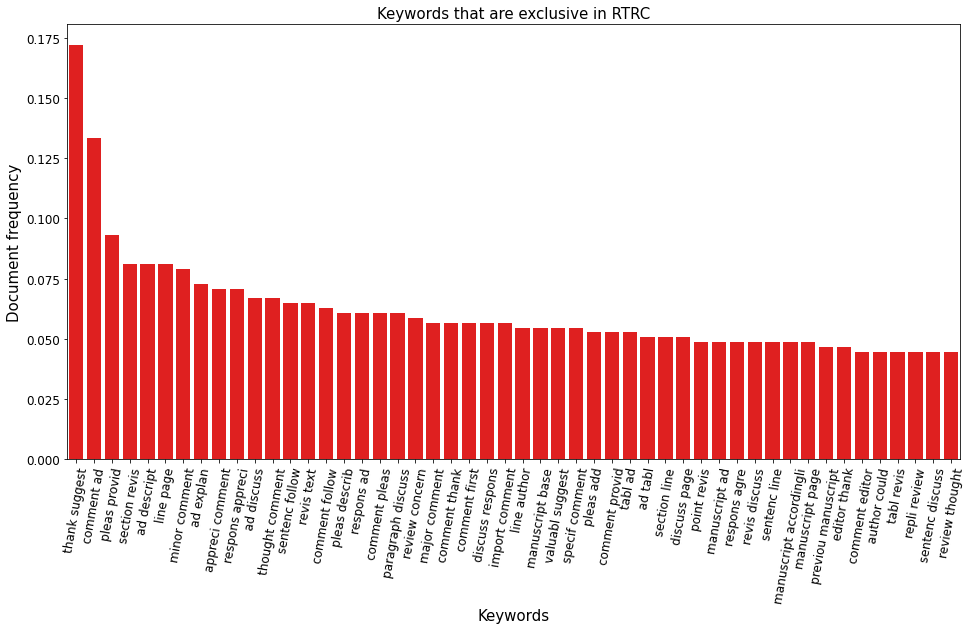

In [ ]:
#For Response to Reviewer Comments
only_rtrc_keywords = np.array(list(set(rtrc_keywords) - set(abstract_keywords) - set(rp_keywords)))
only_rtrc_keywords_dfreq = np.array([rtrc_keyword_dfreq_dict[i] for i in only_rtrc_keywords])
only_rtrc_keywords = only_rtrc_keywords[np.argsort(only_rtrc_keywords_dfreq)][::-1]
only_rtrc_keywords_dfreq = only_rtrc_keywords_dfreq[np.argsort(only_rtrc_keywords_dfreq)][::-1]

fig = plt.figure(figsize = (16,8))
sns.barplot(x = only_rtrc_keywords[:50], y = only_rtrc_keywords_dfreq[:50], color = "red")
plt.xticks(rotation = 80, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Keywords that are exclusive in RTRC", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency", fontsize = 15)
plt.show()

# Keyword Analysis(only Headings)

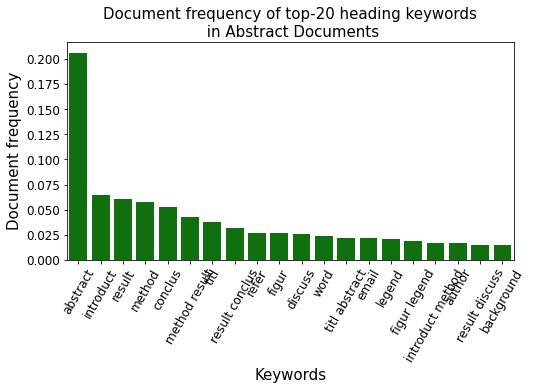

In [ ]:
#Finding Most Frequent Words for Abstracts
abstract_df = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == 'Abstract']

#Finding Document Frequency of each keyword
tfidf_abstract_headings = TfidfVectorizer(tokenizer=tokenize, ngram_range = (1,2), use_idf = None, norm = None, binary = True)
abstract_headings_vector = tfidf_abstract_headings.fit_transform(abstract_df.heading_text)
abstract_headings_vector_df = pd.DataFrame(abstract_headings_vector.toarray())
abstract_headings_vector_df.columns = tfidf_abstract_headings.get_feature_names_out()

doc_freq = abstract_headings_vector_df.sum(axis = 0).values
abstract_headings_keywords = abstract_headings_vector_df.sum(axis = 0).index[np.argsort(doc_freq)[::-1]]
abstract_headings_sort_doc_freq = np.sort(doc_freq)[::-1]/abstract_df.shape[0]

#Plotting top 20 keywords in terms of document frequency within Abstract Category
fig = plt.figure(figsize = (8,4))
sns.barplot(x = abstract_headings_keywords[:20], y = abstract_headings_sort_doc_freq[:20], color = "green")
plt.xticks(rotation = 60, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Document frequency of top-20 heading keywords\n in Abstract Documents", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency", fontsize = 15)
plt.show()

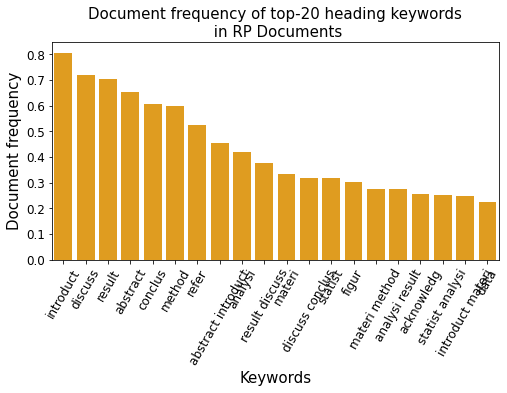

In [ ]:
#Finding Most Frequent Words for Abstracts
rp_df = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == 'Research paper_Journal article']

#Finding Document Frequency of each keyword
tfidf_rp_headings = TfidfVectorizer(tokenizer=tokenize, ngram_range = (1,2), use_idf = None, norm = None, binary = True)
rp_headings_vector = tfidf_rp_headings.fit_transform(rp_df.heading_text)
rp_headings_vector_df = pd.DataFrame(rp_headings_vector.toarray())
rp_headings_vector_df.columns = tfidf_rp_headings.get_feature_names_out()

doc_freq = rp_headings_vector_df.sum(axis = 0).values
rp_headings_keywords = rp_headings_vector_df.sum(axis = 0).index[np.argsort(doc_freq)[::-1]]
rp_headings_sort_doc_freq = np.sort(doc_freq)[::-1]/rp_df.shape[0]

#Plotting top 20 keywords in terms of document frequency within Research Paper Category
fig = plt.figure(figsize = (8,4))
sns.barplot(x = rp_headings_keywords[:20], y = rp_headings_sort_doc_freq[:20], color = "orange")
plt.xticks(rotation = 60, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Document frequency of top-20 heading keywords\n in RP Documents", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency", fontsize = 15)
plt.show()

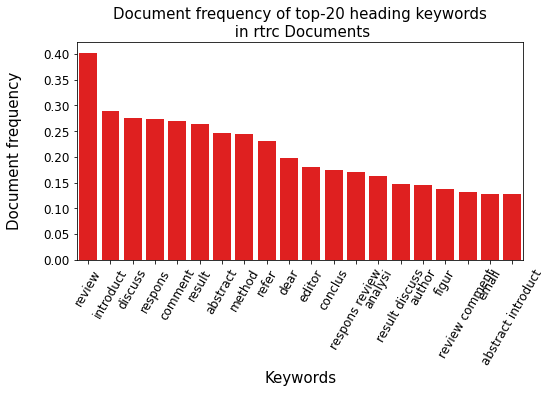

In [ ]:
#Finding Most Frequent Words for Abstracts
rtrc_df = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category == 'Response to reviewer comments']

#Finding Document Frequency of each keyword
tfidf_rtrc_headings = TfidfVectorizer(tokenizer=tokenize, ngram_range = (1,2), use_idf = None, norm = None, binary = True)
rtrc_headings_vector = tfidf_rtrc_headings.fit_transform(rtrc_df.heading_text)
rtrc_headings_vector_df = pd.DataFrame(rtrc_headings_vector.toarray())
rtrc_headings_vector_df.columns = tfidf_rtrc_headings.get_feature_names_out()

doc_freq = rtrc_headings_vector_df.sum(axis = 0).values
rtrc_headings_keywords = rtrc_headings_vector_df.sum(axis = 0).index[np.argsort(doc_freq)[::-1]]
rtrc_headings_sort_doc_freq = np.sort(doc_freq)[::-1]/rtrc_df.shape[0]

#Plotting top 20 keywords in terms of document frequency within RTRC Category
fig = plt.figure(figsize = (8,4))
sns.barplot(x = rtrc_headings_keywords[:20], y = rtrc_headings_sort_doc_freq[:20], color = "red")
plt.xticks(rotation = 60, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Document frequency of top-20 heading keywords\n in rtrc Documents", fontsize = 15)
plt.xlabel("Keywords", fontsize = 15)
plt.ylabel("Document frequency\n", fontsize = 15)
plt.show()

# Find unique heading keyword for each category

In [ ]:
abstract_headings_keyword_dfreq_dict = {}
for i,j in zip(abstract_headings_keywords, abstract_headings_sort_doc_freq):
  abstract_headings_keyword_dfreq_dict[i] = j
rtrc_headings_keyword_dfreq_dict = {}
for i,j in zip(rtrc_headings_keywords, rtrc_headings_sort_doc_freq):
  rtrc_headings_keyword_dfreq_dict[i] = j
rp_headings_keyword_dfreq_dict = {}
for i,j in zip(rp_headings_keywords, rp_headings_sort_doc_freq):
  rp_headings_keyword_dfreq_dict[i] = j

In [ ]:
only_abstract_headings_keywords = np.array(list(set(abstract_headings_keywords) - set(rtrc_headings_keywords) - set(rp_headings_keywords)))
only_abstract_headings_keywords_dfreq = np.array([abstract_headings_keyword_dfreq_dict[i] for i in only_abstract_headings_keywords])
only_abstract_headings_keywords = only_abstract_headings_keywords[np.argsort(only_abstract_headings_keywords_dfreq)][::-1]
only_abstract_headings_keywords_dfreq = only_abstract_headings_keywords_dfreq[np.argsort(only_abstract_headings_keywords_dfreq)][::-1]

print(f'Only abstract heading keyword:{only_abstract_headings_keywords}')

Only abstract heading keyword:['abstract abstract' 'spss' 'phph' ... 'hkmbm dzetak' 'labeleqflinear'
 'partialipartialjf']


In [ ]:
only_rp_headings_keywords = np.array(list(set(rp_headings_keywords) - set(rtrc_headings_keywords) - set(rp_headings_keywords)))
only_rp_headings_keywords_dfreq = np.array([rp_headings_keyword_dfreq_dict[i] for i in only_rp_headings_keywords])
only_rp_headings_keywords = only_rp_headings_keywords[np.argsort(only_rp_headings_keywords_dfreq)][::-1]
only_rp_headings_keywords_dfreq = only_rp_headings_keywords_dfreq[np.argsort(only_rp_headings_keywords_dfreq)][::-1]

print(f'Only rp heading keyword:{only_rp_headings_keywords}')

Only rp heading keyword:[]


In [ ]:
only_rtrc_headings_keywords = np.array(list(set(rtrc_headings_keywords) - set(rtrc_headings_keywords) - set(rtrc_headings_keywords)))
only_rtrc_headings_keywords_dfreq = np.array([rtrc_headings_keyword_dfreq_dict[i] for i in only_rtrc_headings_keywords])
only_rtrc_headings_keywords = only_rtrc_headings_keywords[np.argsort(only_rtrc_headings_keywords_dfreq)][::-1]
only_rtrc_headings_keywords_dfreq = only_rtrc_headings_keywords_dfreq[np.argsort(only_rtrc_headings_keywords_dfreq)][::-1]

print(f'Only rtrc heading keyword:{only_rtrc_headings_keywords}')

Only rtrc heading keyword:[]
